In [ ]:
!pip3 install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163698 sha256=61ced5cf092d02903907bb4adb282ee37d19fcfbb679cf8b037dbcba453be531
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.preprocessing import normalize
import numpy as np
import random

In [5]:
# Load the movielens-100k dataset
data = Dataset.load_builtin('ml-100k')

# Compute user embeddings
def get_user_embeddings(user_dimension):
  algo = NMF(n_factors=user_dimension)
  # algo = NMF(n_factors=user_dimension, init_low=0, init_high=10)
  cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
  users = normalize(algo.pu, "l1")
  #users = algo.pu
  return users

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


# New Section

In [6]:
def linear_probability(content_vector, remaining_array, user_array):
  #this returns a 1x num_users vector representing the probability for each user to be shown this content
  product = user_array @ np.vstack((remaining_array, content_vector)).T
  return (product/product.sum(axis=1)[:,None])[:,-1]

In [9]:
def exponential_probability(content_vector, remaining_array, user_array):
    exp = np.exp(user_array@content_vector)[:, None]
    #this returns a 1x num_users vector representing the probability for each user to be shown this content
    rem = user_array @ remaining_array.T
    return (exp/(exp + np.exp(rem.sum(axis=1)[:,None]))).flatten()

In [10]:
def generate_uniform_user(dimension):
  #unifrom sampling form the simplex
  #reference : https://cs.stackexchange.com/questions/3227/uniform-sampling-from-a-simplex
  return np.diff([0] + sorted(np.random.uniform(size=dimension-1)) + [1])

In [11]:
#establishing user variables

user_dimension = 15


##  Simulated 1:
##  Each user is uniformly sampled from simplex

# num_users = 1000
# user_array = np.array([generate_uniform_user(user_dimension) for i in range(num_users)])




##  Simulated 2:
##  Data has a skew, with the total weight being lowest on feature 0 and highest on feature dim-1

# num_users = 1000
# feature_weights = np.sort(generate_uniform_user(user_dimension))
# unweighted_array = np.array([generate_uniform_user(user_dimension) for i in range(num_users)])
# user_array = normalize(np.multiply(feature_weights,unweighted_array),"l1")

# print("Chosen feature weights",feature_weights)
# print("Total weight in each feature:",sum(user_array)/len(user_array))



##  Real data:
##  Users are generated from movielens 100k (1000 users)

user_array = get_user_embeddings(user_dimension)
num_user = len(user_array)

# print("User array:")
# print(user_array[:5])
# print("Total weight on each feature:")
# print(sum(user_array)/len(user_array))

# for i in range(user_dimension):
#   print("Variance of feature",i,":")
#   print(np.var(user_array[:,i]))

In [12]:
print("User array:")
print(user_array[:5])
print("Total weight on each feature:")
print(sum(user_array)/len(user_array))

User array:
[[0.06200176 0.05733602 0.06694944 0.03239418 0.07773437 0.06533014
  0.07783051 0.01932834 0.08834694 0.08183893 0.09515003 0.05577798
  0.09522559 0.07637741 0.04837835]
 [0.00812675 0.0764985  0.0240998  0.05391487 0.02278484 0.07500964
  0.13003283 0.08715303 0.09793875 0.03186172 0.16708645 0.01740907
  0.06662304 0.06525654 0.07620417]
 [0.08135482 0.09543103 0.08830889 0.05613303 0.06451917 0.0884662
  0.11330162 0.06916923 0.04483584 0.04646717 0.04992172 0.0214303
  0.07208394 0.05184661 0.05673042]
 [0.05770735 0.05664936 0.05625557 0.09394397 0.06776839 0.06745767
  0.04423595 0.07076395 0.08382794 0.07506153 0.07522695 0.04270871
  0.05052206 0.1114311  0.04643952]
 [0.0710718  0.05311346 0.04665182 0.0963837  0.06903784 0.08433869
  0.07065231 0.02819644 0.07504921 0.07044973 0.07202956 0.05283565
  0.08800944 0.09005407 0.03212628]]
Total weight on each feature:
[0.06795439 0.06575474 0.06475005 0.06747171 0.06385616 0.06772346
 0.06790368 0.06805891 0.0676253

In [ ]:
#establishing producer vars
num_producers=100

In [ ]:
def engagement_utility(content_vector, remaining_array, user_array, prob="linear"):
  #Args:
  # Content - The index of the vector representing the content in the producer_array
  # producer_array - a num_prodcuers x d array representing each contetn produced in the system
  # users_array - an num_users x d array represetning all_users and their preferences
  # probability - a function that maps the content and producer_arrary to probability for a piece of content being shown to each user ( 1x num_users vector)
  if prob == "linear":
    probability_function = linear_probability
  elif prob == "exponential":
    probability_function = exponential_probability
  #get probabilty for each user
  probs = probability_function(content_vector, remaining_array, user_array)
  #get value for each user
  prods = user_array @ content_vector
  #since we define all users, we can just take an average
  #TODO: make a version of this for a distribution of users
  return sum(probs*prods)/num_users

In [ ]:
def get_best_response(remaining_array, user_array, prob="linear"):
  #gets the best response to the other contents given the user array
  #TODO: this is probably dumb and there is a better way of doing it

  # Args:
  # remaining_array - the array representing the content of the remaining producers
  # users_array - an num_users x d array representing all_users and their preferences
  max_util = -1
  best_row = None
  for row in np.eye(user_dimension):
    util = engagement_utility(row, remaining_array, user_array, prob=prob)
    if util> max_util:
      best_row = row
      max_util = util
  return best_row

In [ ]:
def eval_position(producer_array, user_array, prob="linear"):
  #returns True if all content vectors are the best response to one another given the user array
  for i, content in enumerate(producer_array):
    row = get_best_response(np.delete(producer_array, i, 0), user_array, prob)
    if not np.all(row==content):
      return False
  return True

In [ ]:
##This is slow, so skip it if you dont need it
#This generates all possible combinations of producers given the dimesnsion and number of producers

def equivalent_combinations(combinations):
  s = set()
  for c in combinations:
    s.add(tuple(sorted(c)))
  return s

def generate_equilibria(user_array):
  results = []
  combinations = np.array(np.meshgrid(*[np.arange(user_dimension) for i in range(num_producers)])).T.reshape(-1, num_producers)
  eq_comb = equivalent_combinations(combinations) # equivalent combinations, just permutation invariant ones of the above
  I = np.eye(user_dimension)
  for combination in eq_comb:
    producer_array = I[list(combination)]
    if eval_position(producer_array, user_array, prob='linear'):
      results.append(tuple(np.sum(producer_array, axis = 0)))
      return list(set(results))

In [ ]:
# Scales better, but still exponential
combinations = np.array(np.meshgrid(*[np.arange(user_dimension) for i in range(num_producers)])).T.reshape(-1, num_producers)
print("length of original search space", len(combinations))
eq_ss = equivalent_combinations(combinations)
print("permutationally invariant search space", len(eq_ss))

In [ ]:
#the default arg for producers just pulls random vectors from the user_dimension-d identity matrix
def search_best_response(users=None, producers=np.eye(user_dimension)[np.random.choice(user_dimension, num_producers)], prob="linear"):
    #working on vectorizing this
    #gets the best reponse for each producer
    idx = np.arange(1, num_producers) - np.tri(num_producers, num_producers-1, k=-1, dtype=bool)
    iter = list(range(num_producers))
    random.shuffle(iter)
    for i in iter:
      row = get_best_response(producers[idx][i], users, prob)
      if not np.all(producers[i] == row):
        producers[i] = row
        return producers, False
    return producers, True

In [ ]:
def get_equilibrium():
  #runs iters of producers searching for linear best reponse
  converged = False
  print("##### PRODUCERS FOR ITER 0\n")
  producers=np.eye(user_dimension)[np.random.choice(user_dimension, num_producers)]
  #producers = np.array([[1,0,0,0,0] for i in range(num_producers)])
  print(producers)
  print("\n")
  i = 1
  while True:
    print(f"##### PRODUCERS FOR ITER {i}\n")
    producers, converged = search_best_response(user_array, producers, prob="exponential")
    print(producers)
    print("\n")
    if converged:
      print(f"Number of iterations to coverge: {i}")
      return np.sum(producers, axis=0)
    i += 1

In [ ]:
# Below is just some search space sizes (ignore)


def countSortedArrays(n, m):
    # Function to find the number of
    # M-length sorted arrays possible
    # using numbers from the range [1, N]

    dp = [0 for _ in range(m + 1)]
    # Base cases
    dp[0] = 1
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            dp[j] = dp[j - 1] + dp[j]
    return dp[m]

print("search space size with 5 dim and 10 producers", countSortedArrays(5, 5))
print("search space size with 5 dim and 10 producers", countSortedArrays(5, 10))
print("search space size with 10 dim and 10 producers", countSortedArrays(10, 10))

scale_nprod = [countSortedArrays(10, n_prod) for n_prod in range(1, 20)] # scaling with # of producers
scale_ndim = [countSortedArrays(n_dim, 10) for n_dim in range(1, 20)] # scaling with # of dimensions

search space size with 5 dim and 10 producers 126
search space size with 5 dim and 10 producers 1001
search space size with 10 dim and 10 producers 92378


In [ ]:
print(scale_nprod)
print(scale_ndim)
import matplotlib.pyplot as plt
plt.plot(np.arange(1,20), scale_nprod, label = 'nprod_scaling')
plt.plot(np.arange(1,20), scale_ndim, label = 'ndim_scaling')
plt.legend()

##### PRODUCERS FOR ITER 0

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### PRODUCERS FOR ITER 1

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### PRODUCERS FOR ITER 2

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### PRODUCERS FOR ITER 3

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### PRODUCERS FOR ITER 4

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### PRODUCERS FOR ITER 5

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0.

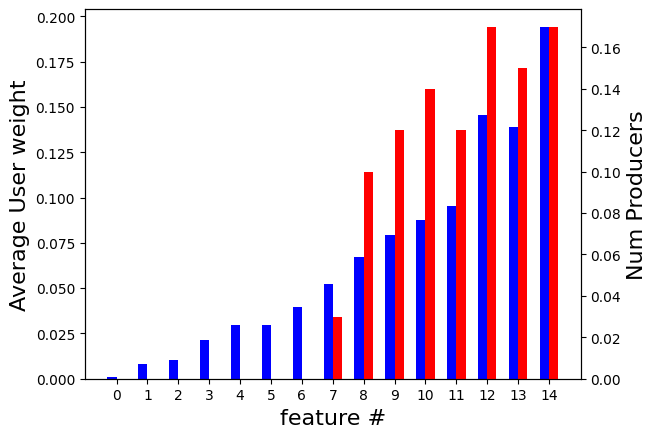

In [ ]:
import matplotlib.pyplot as plt

user_dist = np.sum(user_array,axis=0)/(np.sum(user_array))
producer_dist=get_equilibrium()
producer_dist = producer_dist/np.sum(producer_dist) #Juba: added so that it is renormalized to the same scale as user_dist, i.e. the fraction of producers
#that go for a certain feature

x1,y1 = list(range(user_dimension)), user_dist
x2,y2 = list(range(user_dimension)), producer_dist

fig, ax = plt.subplots()
ax.bar(np.array(x1)-0.15, y1, width = 0.3, color='blue')
ax.set_ylabel('Average User weight', fontsize=16)
ax.set_xlabel('feature #', fontsize=16)

ax2 = ax.twinx()
ax2.bar(np.array(x2)+0.15, y2, width = 0.3, color='red')
ax2.set_ylabel('Num Producers', fontsize=16)

plt.xticks(range(min(x1+x2), max(x1+x2)+1))
plt.show()